In [1]:
import scipy.io
import torch.nn as nn
import torch

# ANFIS из первого примера (200 треков)

In [2]:
sdre_mat_path = "./matlab/sdre_res.mat"
anfis_mat_path = "./matlab/nfc_res.mat"

gt_sdre = scipy.io.loadmat(sdre_mat_path)["sdre_res"]
anfis_output = scipy.io.loadmat(anfis_mat_path)["nfc_res"]

In [3]:
gt_sdre.shape, anfis_output.shape, gt_sdre.reshape(1, -1).shape, 200 * 101 * 3 * 3

((200, 101, 3, 3), (200, 101, 3, 3), (1, 181800), 181800)

In [4]:
gt_sdre = gt_sdre.reshape(1, -1)
gt_sdre = torch.Tensor(gt_sdre)

anfis_output = anfis_output.reshape(1, -1)
anfis_output = torch.Tensor(anfis_output)

In [5]:
criteria = nn.MSELoss()
criteria(anfis_output, gt_sdre)

tensor(0.0092)

# Тест на разном числе треков

In [6]:
from data_utils import split_data_to_traj_and_control, mat2tracks
import wandb
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from pathlib import Path

In [7]:
criteria = nn.MSELoss()

In [9]:
data_root = "./data"
data_root = Path("./data")
folder_names = os.listdir(data_root)
folder_names.sort(key = lambda x: int(x.split("_")[0]))
folder_paths = [data_root / i for i in folder_names]
# folder_paths.pop(2)  # удаление неправильного файла с 50 треками
# folder_paths.pop(3)  # удаление неправильного файла с 50 треками
folder_paths

[WindowsPath('data/10_traj'),
 WindowsPath('data/25_traj'),
 WindowsPath('data/50_traj'),
 WindowsPath('data/100_traj'),
 WindowsPath('data/500_traj'),
 WindowsPath('data/750_traj'),
 WindowsPath('data/1000_traj')]

In [14]:
# cur_dir_path =  folder_paths[0]

n_traj = []
losses = []


for cur_dir_path in folder_paths:
    sdre_mat_path = cur_dir_path / "sdre_res.mat"
    anfis_mat_path = cur_dir_path / "nfc_res.mat"

    gt_sdre = scipy.io.loadmat(sdre_mat_path)["sdre_res"]
    anfis_output = scipy.io.loadmat(anfis_mat_path)["nfc_res"]
    print(anfis_output.shape)

    gt_sdre = gt_sdre.reshape(1, -1)
    gt_sdre = torch.Tensor(gt_sdre)
    anfis_output = anfis_output.reshape(1, -1)
    anfis_output = torch.Tensor(anfis_output)

    n_traj.append(int(str(cur_dir_path).split("\\")[1].split("_")[0]))
    losses.append(criteria(anfis_output, gt_sdre).item())

(10, 101, 3, 3)
(25, 101, 3, 3)
(50, 101, 3, 3)
(100, 101, 3, 3)
(500, 101, 3, 3)
(750, 101, 3, 3)
(1000, 101, 3, 3)


In [11]:
n_traj

[10, 25, 50, 100, 500, 750, 1000]

In [12]:
losses

[0.02413099817931652,
 0.019077040255069733,
 0.011517120525240898,
 0.014652514830231667,
 0.010330118238925934,
 0.010412239469587803,
 0.01038480456918478]

Text(0, 0.5, 'MSE ANFIS на валидации')

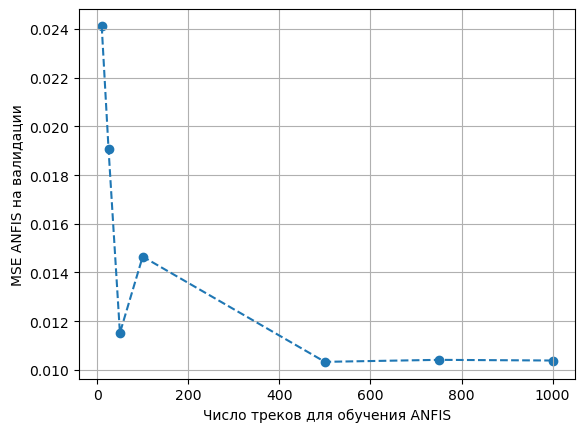

In [13]:
# n_traj[2] = 100

plt.scatter(n_traj, losses)
plt.plot(n_traj, losses, "--")
plt.grid()
plt.xlabel("Число треков для обучения ANFIS")
plt.ylabel("MSE ANFIS на валидации")

In [19]:
import pickle

save_data = {"n_traj" : n_traj, 
             "losses" : losses}

with open("anfis_stats.pickle", 'wb') as handle:
    pickle.dump(save_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# with open("anfis_stats.pickle", 'rb') as handle:
#     unserialized_data = pickle.load(handle)

# unserialized_data